In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from scipy.stats import bernoulli
from scipy.spatial.distance import pdist

%matplotlib inline

In [63]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 64 * 3 * 3

lr = 0.001

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(3, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.pool3 = nn.AvgPool2d(3, stride=2)
        
        self.fc4 = nn.Linear(64 * 3 * 3, 10)
        
    def forward(self, x):
        activation_1 = F.relu(self.pool1(self.conv1(x)))
        activation_2 = F.relu(self.pool2(self.conv2(self.bn1(activation_1))))
        activation_3 = F.relu(self.pool3(self.conv3(self.bn2(activation_2))))
        activation_3 = activation_3.view(-1, 64 * 3 * 3)
        out = self.fc4(activation_3)
        return out, [torch.sign(activation_1.view(-1, 32 * 15 * 15)).cpu().data.numpy(), torch.sign(activation_2.view(-1, 32 * 7 * 7)).cpu().data.numpy(), torch.sign(activation_3).cpu().data.numpy()]
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): AvgPool2d (
  )
  (fc4): Linear (576 -> 10)
)


In [65]:
class Constellation():
    
    train_activations_0 = 0
    train_activations_1 = 0
    train_activations_2 = 0
    
    def __init__(self):
        self.train_activations_0 = 0
        self.train_activations_1 = 0
        self.train_activations_2 = 0
    
    def train_add(self, x):
        if type(self.train_activations_0) is np.ndarray:
            self.train_activations_0 = np.append(self.train_activations_0, x[0], axis=0)
            self.train_activations_1 = np.append(self.train_activations_1, x[1], axis=0)
            self.train_activations_2 = np.append(self.train_activations_2, x[2], axis=0)
        else:
            self.train_activations_0 = x[0]
            self.train_activations_1 = x[1]
            self.train_activations_2 = x[2]
    
    def num_linkage_below_threshold(self, Z, distance, num_elem):
        elem_in_linkage = len(Z)
        count_clusters = 0
        elems_seen = {}
        
        for i in Z:
            # Check if this cluster is made with a good distance.
            if i[2] <= distance:
                count_clusters += 1
                if i[0] >= elem_in_linkage:
                    count_clusters -= 1
                else:
                    elems_seen[i[0]] = 1
                if i[1] >= elem_in_linkage:
                    count_clusters -= 1 
                else:
                    elems_seen[i[1]] = 1
        count_clusters += num_elem - len(elems_seen.keys())
        
        # print('Number of clusters :%d ' % (count_clusters))
        return count_clusters
    
    def curve_clusters_count(self, Z, num_elem):
        X = np.arange(10, num_elem[1], 10)
        Y = []
        for i in X:
            Y += [self.num_linkage_below_threshold(Z, i, num_elem[0])]
        plt.plot(X, Y)
        plt.xlim(10, num_elem[1])
        plt.show()
                
        
    def print_metrics(self):
        print('Layer 1')
        Z = linkage(self.train_activations_0.shape[1] * pdist(self.train_activations_0, metric='hamming'), 'complete', metric='precomputed')
        print('Linkage count ...')
        self.curve_clusters_count(Z, self.train_activations_0.shape)
        
        print('Layer 2')
        Z = linkage(self.train_activations_1.shape[1] * pdist(self.train_activations_1, metric='hamming'), 'complete', metric='precomputed')
        print('Linkage count ...')
        self.curve_clusters_count(Z, self.train_activations_1.shape)
        
        print('Layer 3')
        Z = linkage(self.train_activations_2.shape[1] * pdist(self.train_activations_2, metric='hamming'), 'complete', metric='precomputed')
        print('Linkage count ...')
        self.curve_clusters_count(Z, self.train_activations_2.shape)
#         print('Plot ...')
#         plt.figure(figsize=(25, 10))
#         plt.title('Hierarchical Clustering Dendrogram')
#         plt.xlabel('sample index')
#         plt.ylabel('distance')
#         dendrogram(
#             Z,
#             leaf_rotation=90.,  # rotates the x axis labels
#             leaf_font_size=8.,  # font size for the x axis labels
#             color_threshold = 100
#         )
#         plt.show()
        
        
        

In [66]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [67]:
if cuda:
    model.cuda()
    criterion.cuda()

In [68]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = Constellation()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations)
        if batch_idx > 100:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()

Layer 1
Linkage count ...


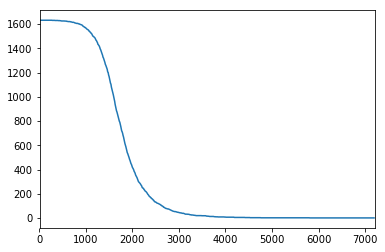

Layer 2
Linkage count ...


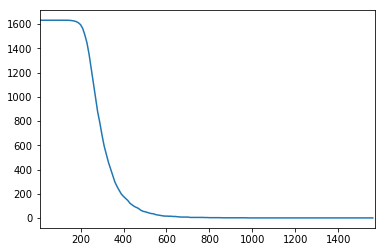

Layer 3
Linkage count ...


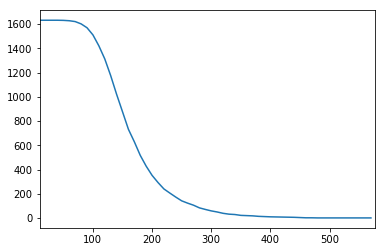

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.294552
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.921580
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.563455
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.290059
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.943739
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.072217
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.221010
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.366785

Test set: Average loss: 1.1538, Accuracy: 5910/10000 (59%)

Layer 1
Linkage count ...


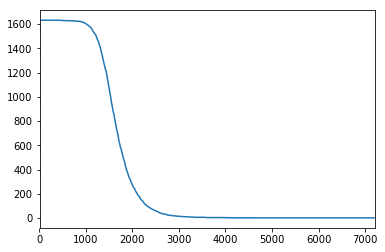

Layer 2
Linkage count ...


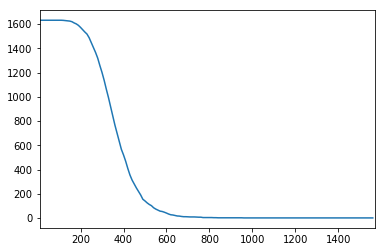

Layer 3
Linkage count ...


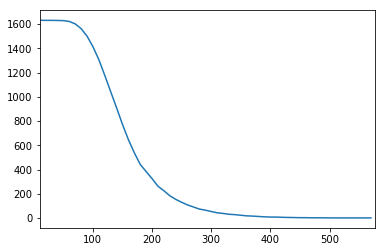

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.267385
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.956111
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.662679
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.450717
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.352907
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.332290
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.997055
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.225375

Test set: Average loss: 0.9413, Accuracy: 6704/10000 (67%)

Layer 1
Linkage count ...


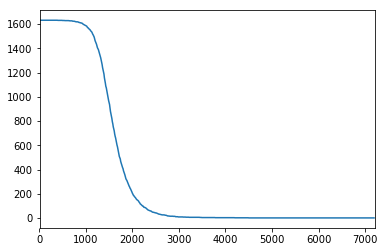

Layer 2
Linkage count ...


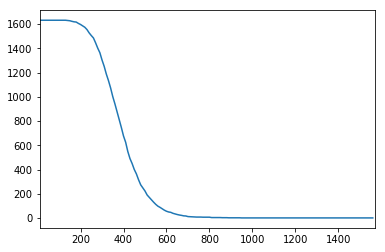

Layer 3
Linkage count ...


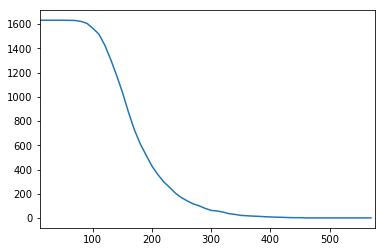

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.015115
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.976645
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.034540
Train Epoch: 3 [19200/50000 (38%)]	Loss: 0.934002
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.735592
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.987726
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.706435
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.294203

Test set: Average loss: 0.8411, Accuracy: 7063/10000 (71%)

Layer 1
Linkage count ...


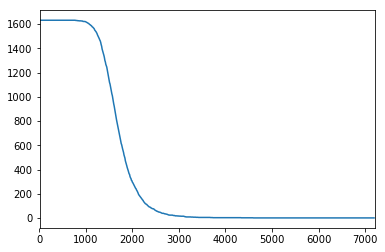

Layer 2
Linkage count ...


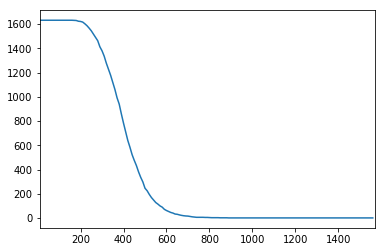

Layer 3
Linkage count ...


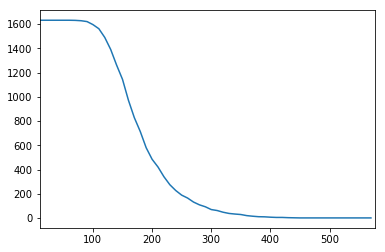

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.354125
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.794262
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.806511
Train Epoch: 4 [19200/50000 (38%)]	Loss: 0.848044
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.472070
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.920577
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.769863
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.684427

Test set: Average loss: 0.7626, Accuracy: 7369/10000 (74%)

Layer 1
Linkage count ...


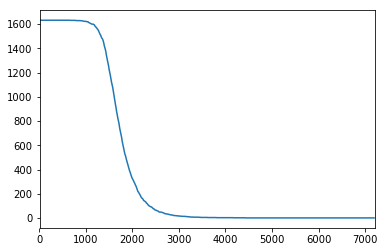

Layer 2
Linkage count ...


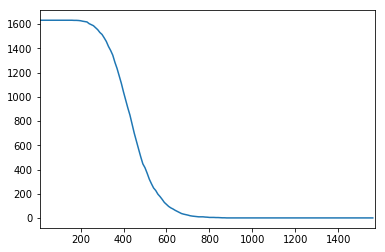

Layer 3
Linkage count ...


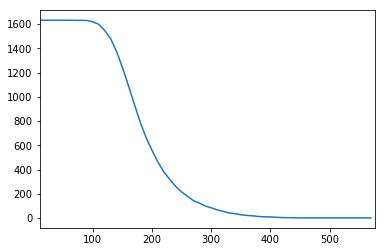

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.465014
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.600314
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.449696
Train Epoch: 5 [19200/50000 (38%)]	Loss: 0.373562
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.474752
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.384197
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.462709
Train Epoch: 5 [44800/50000 (90%)]	Loss: 0.264714

Test set: Average loss: 0.7452, Accuracy: 7411/10000 (74%)

Layer 1
Linkage count ...


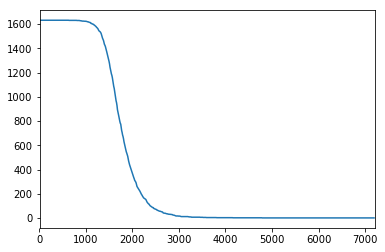

Layer 2
Linkage count ...


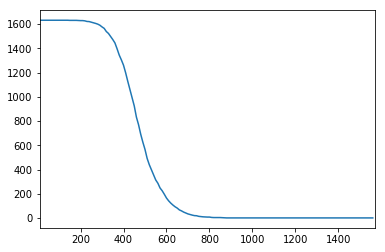

Layer 3
Linkage count ...


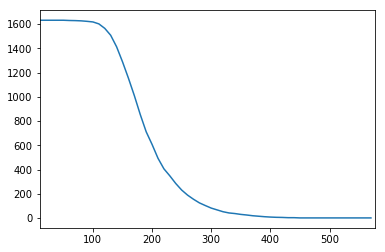

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.701412
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.002039
Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.376503
Train Epoch: 6 [19200/50000 (38%)]	Loss: 0.498874
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.359637
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.062059
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.337355
Train Epoch: 6 [44800/50000 (90%)]	Loss: 0.519116

Test set: Average loss: 0.7238, Accuracy: 7492/10000 (75%)

Layer 1
Linkage count ...


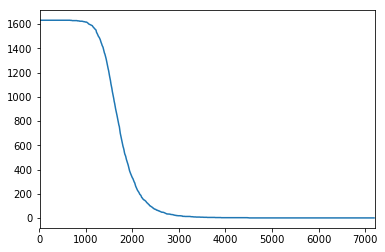

Layer 2
Linkage count ...


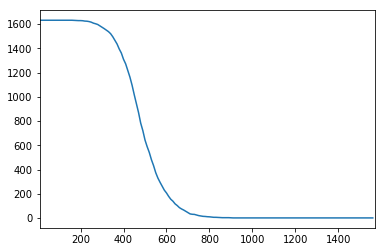

Layer 3
Linkage count ...


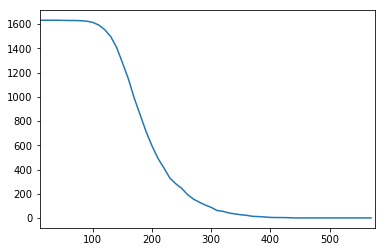

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.730802
Train Epoch: 7 [6400/50000 (13%)]	Loss: 0.479034
Train Epoch: 7 [12800/50000 (26%)]	Loss: 0.695803
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.061938
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.528592
Train Epoch: 7 [32000/50000 (64%)]	Loss: 0.192527
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.044377
Train Epoch: 7 [44800/50000 (90%)]	Loss: 0.340698

Test set: Average loss: 0.7132, Accuracy: 7476/10000 (75%)

Layer 1
Linkage count ...


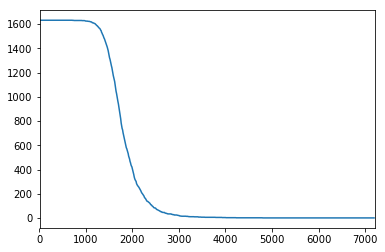

Layer 2
Linkage count ...


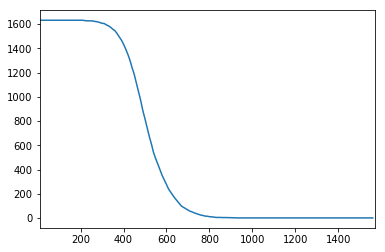

Layer 3
Linkage count ...


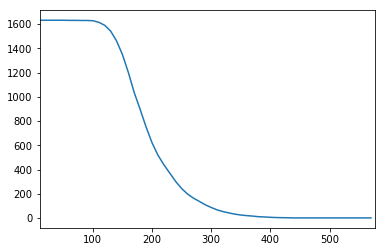

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.964964
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.510959
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.757780
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.476124
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.858906
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.905827
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.554057
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.511726

Test set: Average loss: 0.6980, Accuracy: 7581/10000 (76%)

Layer 1
Linkage count ...


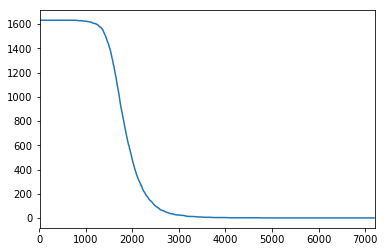

Layer 2
Linkage count ...


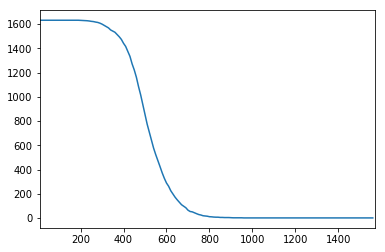

Layer 3
Linkage count ...


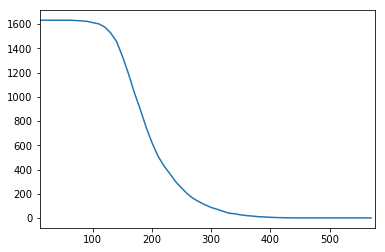

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.349232
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.460414
Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.588944
Train Epoch: 9 [19200/50000 (38%)]	Loss: 0.946177
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.632613
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.184831
Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.198097
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.954652

Test set: Average loss: 0.6885, Accuracy: 7618/10000 (76%)

Layer 1
Linkage count ...


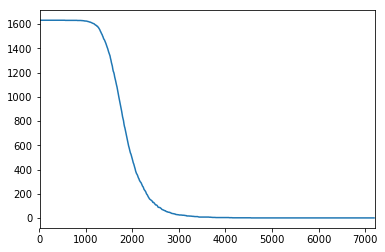

Layer 2
Linkage count ...


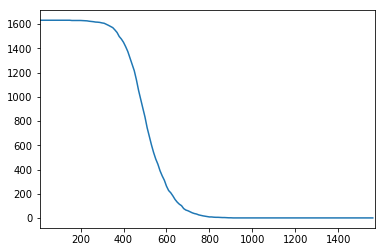

Layer 3
Linkage count ...


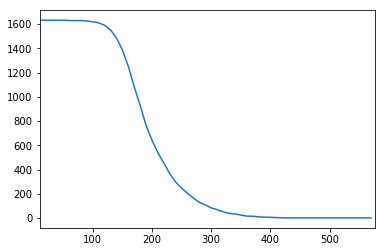

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.460200
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.413189
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.380720
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.818614
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.474144
Train Epoch: 10 [32000/50000 (64%)]	Loss: 0.322167
Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.545484
Train Epoch: 10 [44800/50000 (90%)]	Loss: 0.450441

Test set: Average loss: 0.6597, Accuracy: 7733/10000 (77%)

Layer 1
Linkage count ...


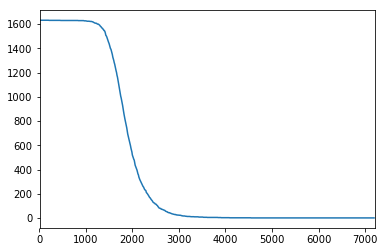

Layer 2
Linkage count ...


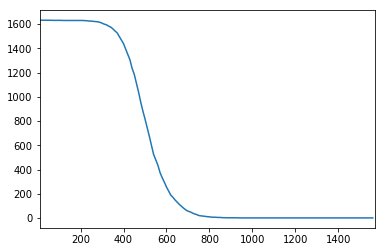

Layer 3
Linkage count ...


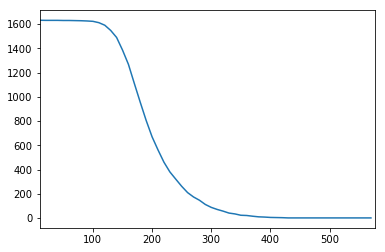

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.484710
Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.523878
Train Epoch: 11 [12800/50000 (26%)]	Loss: 0.757622
Train Epoch: 11 [19200/50000 (38%)]	Loss: 0.458435
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.700245
Train Epoch: 11 [32000/50000 (64%)]	Loss: 0.899604
Train Epoch: 11 [38400/50000 (77%)]	Loss: 0.492875
Train Epoch: 11 [44800/50000 (90%)]	Loss: 0.478144

Test set: Average loss: 0.6641, Accuracy: 7729/10000 (77%)

Layer 1
Linkage count ...


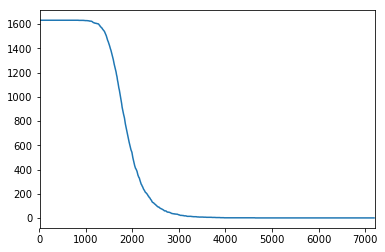

Layer 2
Linkage count ...


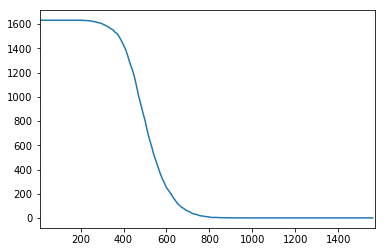

Layer 3
Linkage count ...


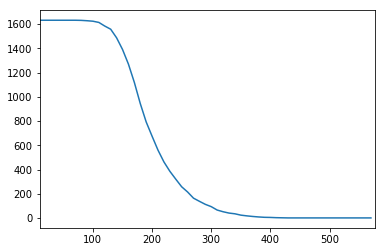

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.543707
Train Epoch: 12 [6400/50000 (13%)]	Loss: 0.567748
Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.000806
Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.218661
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.366542
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.126022
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.229647
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.707503

Test set: Average loss: 0.6748, Accuracy: 7723/10000 (77%)

Layer 1
Linkage count ...


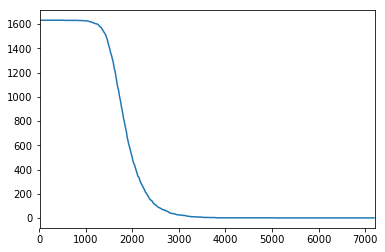

Layer 2
Linkage count ...


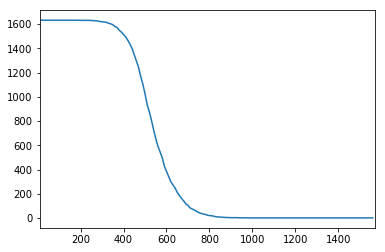

Layer 3
Linkage count ...


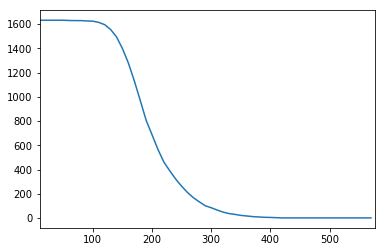

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.453688
Train Epoch: 13 [6400/50000 (13%)]	Loss: 0.203230
Train Epoch: 13 [12800/50000 (26%)]	Loss: 0.868292
Train Epoch: 13 [19200/50000 (38%)]	Loss: 0.552442
Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.591883
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.459768
Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.560316
Train Epoch: 13 [44800/50000 (90%)]	Loss: 0.925471

Test set: Average loss: 0.6780, Accuracy: 7739/10000 (77%)

Layer 1
Linkage count ...


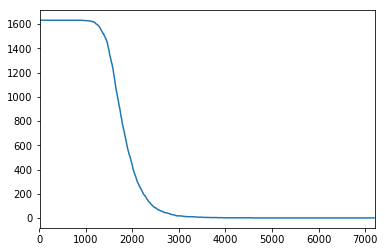

Layer 2
Linkage count ...


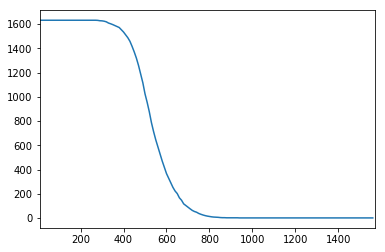

Layer 3
Linkage count ...


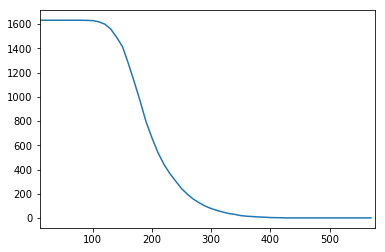

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.367468
Train Epoch: 14 [6400/50000 (13%)]	Loss: 0.344394
Train Epoch: 14 [12800/50000 (26%)]	Loss: 1.191322
Train Epoch: 14 [19200/50000 (38%)]	Loss: 0.727803
Train Epoch: 14 [25600/50000 (51%)]	Loss: 0.126706
Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.250971
Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.005200
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.345769

Test set: Average loss: 0.7004, Accuracy: 7680/10000 (77%)

Layer 1
Linkage count ...


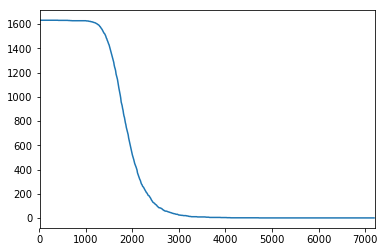

Layer 2
Linkage count ...


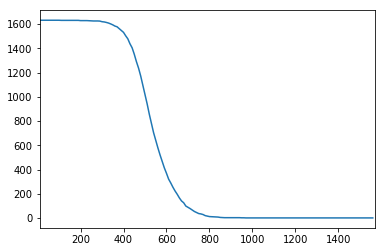

Layer 3
Linkage count ...


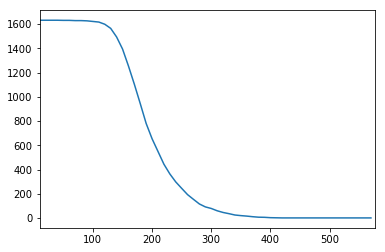

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.431648
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.550958
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.794361
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.432842
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.283424
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.473976
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.825654
Train Epoch: 15 [44800/50000 (90%)]	Loss: 1.042149

Test set: Average loss: 0.6688, Accuracy: 7789/10000 (78%)

Layer 1
Linkage count ...


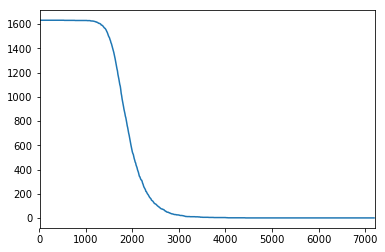

Layer 2
Linkage count ...


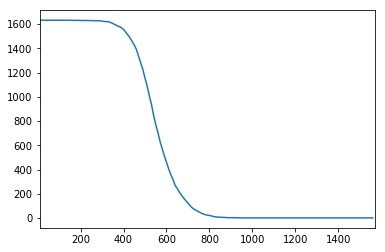

Layer 3
Linkage count ...


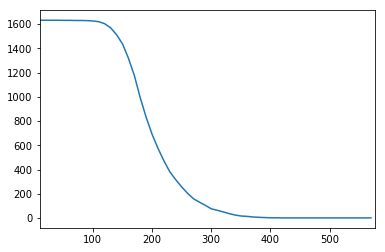

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.218336
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.497527
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.319958
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.641492
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.295223
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.287663
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.226359
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.495499

Test set: Average loss: 0.6665, Accuracy: 7783/10000 (78%)

Layer 1
Linkage count ...


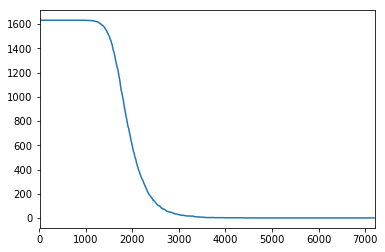

Layer 2
Linkage count ...


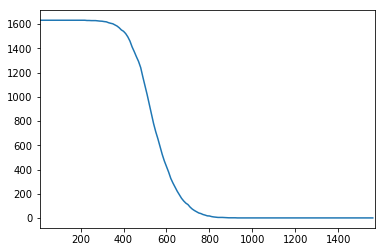

Layer 3
Linkage count ...


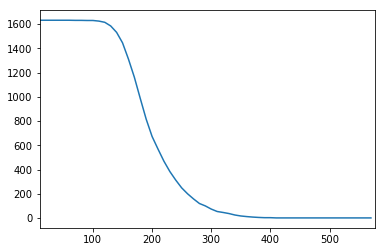

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.367691
Train Epoch: 17 [6400/50000 (13%)]	Loss: 0.229289
Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.808105
Train Epoch: 17 [19200/50000 (38%)]	Loss: 0.478301
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.482999
Train Epoch: 17 [32000/50000 (64%)]	Loss: 0.450838
Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.218217
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.330595

Test set: Average loss: 0.6785, Accuracy: 7776/10000 (78%)

Layer 1
Linkage count ...


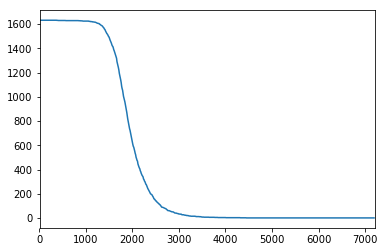

Layer 2
Linkage count ...


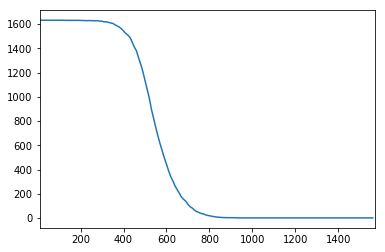

Layer 3
Linkage count ...


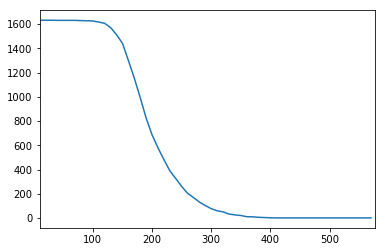

Train Epoch: 18 [0/50000 (0%)]	Loss: 0.277598
Train Epoch: 18 [6400/50000 (13%)]	Loss: 0.417622
Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.449065
Train Epoch: 18 [19200/50000 (38%)]	Loss: 0.269043
Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.425745
Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.627220
Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.166595
Train Epoch: 18 [44800/50000 (90%)]	Loss: 0.330765

Test set: Average loss: 0.6767, Accuracy: 7802/10000 (78%)

Layer 1
Linkage count ...


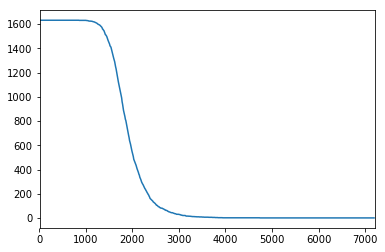

Layer 2
Linkage count ...


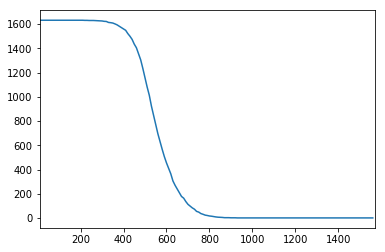

Layer 3
Linkage count ...


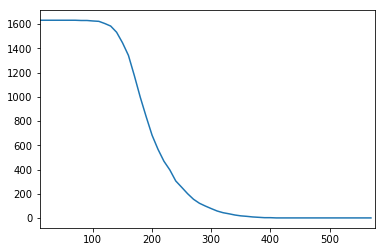

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.453338
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.436628
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.403386
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.261322
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.363849
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.421524
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.371133
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.930679

Test set: Average loss: 0.6835, Accuracy: 7824/10000 (78%)

Layer 1
Linkage count ...


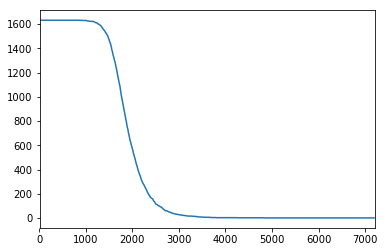

Layer 2
Linkage count ...


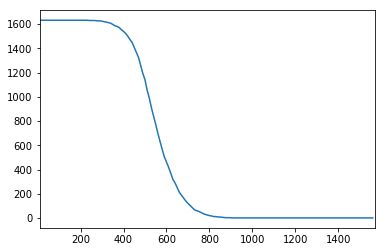

Layer 3
Linkage count ...


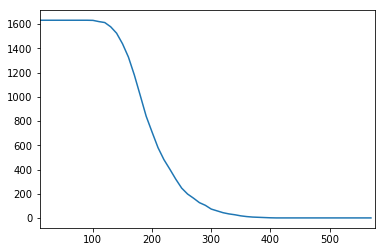

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.263829
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.243587
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.421126
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.261788
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.242239
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.258668
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.221555
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.367233

Test set: Average loss: 0.6898, Accuracy: 7779/10000 (78%)



In [69]:
# activation_metrics()

for epoch in range(1, epochs + 1):
    activation_metrics()
    train(epoch)
    test(epoch)